# Download data

In [1]:
#!wget http://158.109.8.102/AppaRealAge/appa-real-release.zip

In [2]:
#!cp /content/appa-real-release.zip /content/drive/MyDrive/MAP583/
!cp /content/drive/MyDrive/MAP583/appa-real-release.zip /content/

In [3]:
!unzip appa-real-release.zip

Archive:  appa-real-release.zip
replace appa-real-release/gt_avg_valid.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
#!cp /content/new_train.zip /content/drive/MyDrive/MAP583/
!cp /content/drive/MyDrive/MAP583/new_train.zip /content/

In [5]:
!rm -rf new_train

In [6]:
!unzip new_train.zip

Archive:  new_train.zip
   creating: new_train/
  inflating: new_train/0_000001.jpg  
  inflating: new_train/0_000002.jpg  
  inflating: new_train/0_000005.jpg  
  inflating: new_train/0_000006.jpg  
  inflating: new_train/0_000007.jpg  
  inflating: new_train/0_000008.jpg  
  inflating: new_train/0_000009.jpg  
  inflating: new_train/0_000010.jpg  
  inflating: new_train/0_000011.jpg  
  inflating: new_train/0_000012.jpg  
  inflating: new_train/0_000013.jpg  
  inflating: new_train/0_000014.jpg  
  inflating: new_train/0_000015.jpg  
  inflating: new_train/0_000016.jpg  
  inflating: new_train/0_000017.jpg  
  inflating: new_train/0_000018.jpg  
  inflating: new_train/0_000019.jpg  
  inflating: new_train/0_000020.jpg  
  inflating: new_train/0_000021.jpg  
  inflating: new_train/0_000022.jpg  
  inflating: new_train/0_000023.jpg  
  inflating: new_train/0_000024.jpg  
  inflating: new_train/0_000025.jpg  
  inflating: new_train/0_000026.jpg  
  inflating: new_train/0_000027.jpg  
  

In [7]:
#!cp /content/ignore_list.csv /content/drive/MyDrive/MAP583/
!cp /content/drive/MyDrive/MAP583/ignore_list.csv /content/

In [8]:
#!cp /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth /content/drive/MyDrive/MAP583/
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp /content/drive/MyDrive/MAP583/se_resnext50_32x4d-a260b3a4.pth /root/.cache/torch/hub/checkpoints/

# Load dataset

In [1]:
data_dir = "/content/appa-real-release/" #appa-real-release adress
ignore_path = "/content/ignore_list.csv" #ignore_list.csv adress

new_train_dir = "/content/new_train" #new_train adress

## FaceDataset

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from imgaug import augmenters as iaa
import torch
import cv2

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.OneOf([
                iaa.Sometimes(0.25, iaa.AdditiveGaussianNoise(scale=0.1 * 255)),
                iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0)))
                ]),
            iaa.Affine(
                rotate=(-20, 20), mode="edge",
                scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}
            ),
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True),
            iaa.GammaContrast((0.3, 2)),
            iaa.Fliplr(0.5),
        ])

    def __call__(self, img):
        img = np.array(img)
        img = self.aug.augment_image(img)
        return img

class FaceDataset(Dataset):
    def __init__(self, data_dir, data_type, ignore_path=ignore_path, img_size=224, augment=False, age_stddev=1.0):
        assert(data_type in ("train", "valid", "test"))
        csv_path = Path(data_dir).joinpath(f"gt_avg_{data_type}.csv")
        img_dir = Path(data_dir).joinpath(data_type)
        self.img_size = img_size
        self.augment = augment
        self.age_stddev = age_stddev

        if augment:
            self.transform = ImgAugTransform()
        else:
            self.transform = lambda i: i

        self.x = []
        self.y = []
        self.std = []
        df = pd.read_csv(str(csv_path))
        # ignore_path = Path(__file__).resolve().parent.joinpath("ignore_list.csv")
        ignore_img_names = list(pd.read_csv(str(ignore_path))["img_name"].values)

        for _, row in df.iterrows():
            img_name = row["file_name"]

            if img_name in ignore_img_names:
                continue

            img_path = img_dir.joinpath(img_name + "_face.jpg")
            assert(img_path.is_file())
            self.x.append(str(img_path))
            self.y.append(row["apparent_age_avg"])
            self.std.append(row["apparent_age_std"])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_path = self.x[idx]
        age = self.y[idx]

        if self.augment:
            age += np.random.randn() * self.std[idx] * self.age_stddev

        img = cv2.imread(str(img_path), 1)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = self.transform(img).astype(np.float32)
        return torch.from_numpy(np.transpose(img, (2, 0, 1))), np.clip(round(age), 0, 100)

In [3]:
dataset = FaceDataset(data_dir,"train")
print("train dataset len: {}".format(len(dataset)))
print(dataset[0][0].shape)
print(dataset[0][1])

train dataset len: 3995
torch.Size([3, 224, 224])
5


## RandAugment

In [4]:
# code in this file is adpated from
# https://github.com/ildoonet/pytorch-randaugment/blob/master/RandAugment/augmentations.py
# https://github.com/google-research/fixmatch/blob/master/third_party/auto_augment/augmentations.py
# https://github.com/google-research/fixmatch/blob/master/libml/ctaugment.py
import logging
import random

import numpy as np
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image

logger = logging.getLogger(__name__)

PARAMETER_MAX = 10


def AutoContrast(img, **kwarg):
    return PIL.ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Cutout(img, v, max_v, bias=0):
    if v == 0:
        return img
    v = _float_parameter(v, max_v) + bias
    v = int(v * min(img.size))
    return CutoutAbs(img, v)


def CutoutAbs(img, v, **kwarg):
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    # gray
    color = (127, 127, 127)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Equalize(img, **kwarg):
    return PIL.ImageOps.equalize(img)


def Identity(img, **kwarg):
    return img


def Invert(img, **kwarg):
    return PIL.ImageOps.invert(img)


def Posterize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.posterize(img, v)


def Rotate(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.rotate(v)


def Sharpness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def Solarize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, bias=0, threshold=128):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)


def fixmatch_augment_pool():
    # FixMatch paper
    augs = [(AutoContrast, None, None),
            (Brightness, 0.9, 0.05),
            (Color, 0.9, 0.05),
            (Contrast, 0.9, 0.05),
            (Equalize, None, None),
            (Identity, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 0.9, 0.05),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (TranslateX, 0.3, 0),
            (TranslateY, 0.3, 0)]
    return augs


def my_augment_pool():
    # Test
    augs = [(AutoContrast, None, None),
            (Brightness, 1.8, 0.1),
            (Color, 1.8, 0.1),
            (Contrast, 1.8, 0.1),
            (Cutout, 0.2, 0),
            (Equalize, None, None),
            (Invert, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 1.8, 0.1),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (SolarizeAdd, 110, 0),
            (TranslateX, 0.45, 0),
            (TranslateY, 0.45, 0)]
    return augs


class RandAugmentPC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = my_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            prob = np.random.uniform(0.2, 0.8)
            if random.random() + prob >= 1:
                img = op(img, v=self.m, max_v=max_v, bias=bias)
        img = CutoutAbs(img, int(32*0.5))
        return img


class RandAugmentMC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if random.random() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)
        img = CutoutAbs(img, int(32*0.5))
        return img

## NewFaceDataset

In [5]:
from torchvision import transforms

class TransformFixMatch(object):
    def __init__(self,img_size):
        self.weak = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=img_size,
                                  padding=int(img_size*0.125),
                                  padding_mode='reflect')])
        self.strong = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=img_size,
                                  padding=int(img_size*0.125),
                                  padding_mode='reflect'),
            RandAugmentMC(n=10, m=10)])
        self.to = transforms.ToTensor()
        # self.normalize = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=mean, std=std)])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        # return self.normalize(weak), self.normalize(strong)
        return self.to(weak)*255, self.to(strong)*255

class NewFaceDataset(Dataset):
    def __init__(self, data_dir, img_size=224):
        csv_path = Path(data_dir).joinpath("predicted_age.csv")
        img_dir = Path(data_dir)
        self.img_size = img_size
        self.transform_fixmatch = TransformFixMatch(img_size)

        self.x = []
        df = pd.read_csv(str(csv_path))

        for _, row in df.iterrows():
            img_name = row["file_name"]
            img_path = img_dir.joinpath(img_name)
            assert(img_path.is_file())
            self.x.append(str(img_path))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_path = self.x[idx]

        img = Image.open(img_path)
        r, g, b = img.split()
        img = Image.merge("RGB", (b, g, r))
        img = img.resize((self.img_size, self.img_size))

        return self.transform_fixmatch(img)

In [6]:
dataset = NewFaceDataset(new_train_dir)
print("train dataset len: {}".format(len(dataset)))
print(dataset[0][0].shape)
print(dataset[0][1].shape)

train dataset len: 480
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


# Load Model

In [7]:
MODEL_ARCH = "se_resnext50_32x4d" #MODEL.ARCH in default.py
resume_path = "/content/epoch044_0.02343_3.9984.pth" #resume path
MODEL_IMG_SIZE = 224
TRAIN_AGE_STDDEV = 1.0

In [8]:
!pip install pretrainedmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import torch.nn as nn
import pretrainedmodels

def get_model(model_name="se_resnext50_32x4d", num_classes=101, pretrained="imagenet"):
    model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
    dim_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(dim_feats, num_classes)
    model.avg_pool = nn.AdaptiveAvgPool2d(1)
    return model

In [10]:
import ssl

print("=> creating model '{}'".format(MODEL_ARCH))
ssl._create_default_https_context = ssl._create_unverified_context
model = get_model(model_name=MODEL_ARCH)

=> creating model 'se_resnext50_32x4d'


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [12]:
import urllib
if not Path(resume_path).is_file():
    print(f"=> model path is not set; start downloading trained model")
    url = "https://github.com/yu4u/age-estimation-pytorch/releases/download/v1.0/epoch044_0.02343_3.9984.pth"
    urllib.request.urlretrieve(url, str(resume_path))
    print("=> download finished")
if Path(resume_path).is_file():
    print("=> loading checkpoint '{}'".format(resume_path))
    checkpoint = torch.load(resume_path, map_location="cpu")
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (epoch {})"
            .format(resume_path, checkpoint['epoch']))
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

=> loading checkpoint '/content/epoch044_0.02343_3.9984.pth'
=> loaded checkpoint '/content/epoch044_0.02343_3.9984.pth' (epoch 45)


# Creat dataset

In [13]:
train_dataset_X = FaceDataset(data_dir, "train", img_size=MODEL_IMG_SIZE, augment=True,
                            age_stddev=TRAIN_AGE_STDDEV)

train_dataset_U = NewFaceDataset(new_train_dir, img_size=MODEL_IMG_SIZE)

val_dataset = FaceDataset(data_dir, "valid", img_size=MODEL_IMG_SIZE, augment=False)

# Train

In [14]:
out = "/content/out/"

In [15]:
from tqdm import tqdm
import time
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import LambdaLR
import math
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import os


class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_cosine_schedule_with_warmup(optimizer,num_warmup_steps,num_training_steps,num_cycles=7./16.,last_epoch=-1):
    def _lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        no_progress = float(current_step - num_warmup_steps) / \
            float(max(1, num_training_steps - num_warmup_steps))
        return max(0., math.cos(math.pi * num_cycles * no_progress))

    return LambdaLR(optimizer, _lr_lambda, last_epoch)


def interleave(x, size):
    s = list(x.shape)
    return x.reshape([-1, size] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])


def de_interleave(x, size):
    s = list(x.shape)
    return x.reshape([size, -1] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])

def train(labeled_dataset, unlabeled_dataset, test_dataset, model, n_epochs, n_eval_step, device, out=out, mu=2, batch_size_labeled=8, num_workers=2, lr=1e-5, threshold=0.07, T=1, lambda_u=1):
    """
    n_epochs: total number of epochs
    n_eval_step: number of evaluation steps in each epoch
    mu: coefficient of unlabeled batch size
    batch_size_labeled: batch size of labeled dataset
    threshold: pseudo label threshold
    T: pseudo label temperature
    lambda_u: coefficient of unlabeled loss
    """
    f_writer = open("train_log.txt", "a")

    os.makedirs(out, exist_ok=True)
    writer = SummaryWriter(out)

    optimizer = torch.optim.SGD(model.parameters(),weight_decay=5e-4, lr=lr, momentum=0.9, nesterov=True)
    scheduler = get_cosine_schedule_with_warmup(optimizer, 0, n_epochs*n_eval_step)

    labeled_trainloader = DataLoader(
        labeled_dataset,
        sampler=RandomSampler(labeled_dataset),
        batch_size=batch_size_labeled,
        num_workers=num_workers,
        drop_last=True)

    unlabeled_trainloader = DataLoader(
        unlabeled_dataset,
        sampler=RandomSampler(unlabeled_dataset),
        batch_size=batch_size_labeled*mu,
        num_workers=num_workers,
        drop_last=True)

    test_loader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=batch_size_labeled*mu,
        num_workers=num_workers)
    
    best_mae = 4.5
    maes = []
    end = time.time()

    labeled_iter = iter(labeled_trainloader)
    unlabeled_iter = iter(unlabeled_trainloader)
    model.train()
    model.zero_grad()
    for epoch in range(n_epochs):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        losses_x = AverageMeter()
        losses_u = AverageMeter()
        mask_probs = AverageMeter()

        p_bar = tqdm(range(n_eval_step))
        # train
        for batch_idx in range(n_eval_step):
            try:
                inputs_x, targets_x = next(labeled_iter)
            except:
                labeled_iter = iter(labeled_trainloader)
                inputs_x, targets_x = next(labeled_iter)
            
            try:
                inputs_u_w, inputs_u_s = next(unlabeled_iter)
            except:
                unlabeled_iter = iter(unlabeled_trainloader)
                inputs_u_w, inputs_u_s = next(unlabeled_iter)

            data_time.update(time.time() - end)
            batch_size = inputs_x.shape[0]
            # inputs = interleave(torch.cat((inputs_x, inputs_u_w, inputs_u_s)), 2*mu+1).to(device)
            targets_x = targets_x.to(device)
            # logits = model(inputs)
            # logits = de_interleave(logits, 2*mu+1)
            # logits_x = logits[:batch_size]
            # logits_u_w, logits_u_s = logits[batch_size:].chunk(2)
            # del logits
            logits_x = model(inputs_x.to(device))
            logits_u_w = model(inputs_u_w.to(device))
            logits_u_s = model(inputs_u_s.to(device))
            Lx = F.cross_entropy(logits_x, targets_x, reduction='mean')

            pseudo_label = torch.softmax(logits_u_w.detach()/T, dim=-1)
            max_probs, targets_u = torch.max(pseudo_label, dim=-1)
            mask = max_probs.ge(threshold).float()

            Lu = (F.cross_entropy(logits_u_s, targets_u,
                                  reduction='none') * mask).mean()

            loss = Lx + lambda_u * Lu

            loss.backward()
            losses.update(loss.item())
            losses_x.update(Lx.item())
            losses_u.update(Lu.item())
            optimizer.step()
            scheduler.step()
            model.zero_grad()

            batch_time.update(time.time() - end)
            end = time.time()
            mask_probs.update(mask.mean().item())
            p_bar.set_description("Train Epoch: {epoch}/{epochs:4}. Iter: {batch:4}/{iter:4}. LR: {lr:.4f}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. Loss_x: {loss_x:.4f}. Loss_u: {loss_u:.4f}. Mask: {mask:.2f}. ".format(
                    epoch=epoch + 1,
                    epochs=n_epochs,
                    batch=batch_idx + 1,
                    iter=n_eval_step,
                    lr=scheduler.get_last_lr()[0],
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    loss_x=losses_x.avg,
                    loss_u=losses_u.avg,
                    mask=mask_probs.avg))
            p_bar.update()

        p_bar.close()
        # test
        test_model = model

        test_loss, test_acc, mae = test(test_loader, test_model, epoch, device=device)

        writer.add_scalar('train/1.train_loss', losses.avg, epoch)
        writer.add_scalar('train/2.train_loss_x', losses_x.avg, epoch)
        writer.add_scalar('train/3.train_loss_u', losses_u.avg, epoch)
        writer.add_scalar('train/4.mask', mask_probs.avg, epoch)
        writer.add_scalar('test/1.test_acc', test_acc, epoch)
        writer.add_scalar('test/2.test_loss', test_loss, epoch)
        writer.add_scalar('test/3.test_mae', mae, epoch)

        is_best = mae < best_mae
        best_mae = min(mae, best_mae)

        if is_best:
            model_to_save = model.module if hasattr(model, "module") else model
            torch.save({
                    'epoch': epoch + 1,
                    'state_dict': model_to_save.state_dict(),
                    'loss': test_loss,
                    'acc': test_acc,
                    'mae': mae,
                    'best_mae': best_mae,
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                }, str(Path(out).joinpath("epoch{:03d}_{:.5f}_{:.4f}.pth".format(epoch, test_loss, mae))) )
        maes.append(mae)

        output_test = model(val_dataset[0][0].unsqueeze(0).to(device))
        output_test = torch.softmax(output_test.detach()/1, dim=-1)
        proba_test = output_test.max(1)[0].item()
        pred_test = output_test.max(1)[1].item()
        label_test = labeled_dataset[0][1]

        output_test2 = model(unlabeled_dataset[0][0].unsqueeze(0).to(device))
        output_test2 = torch.softmax(output_test2.detach()/1, dim=-1)
        proba_test2 = output_test2.max(1)[0].item()
        pred_test2 = output_test2.max(1)[1].item()
        f_writer.write("{};{};{};{};{};{};{}\n".format(epoch,mae,pred_test,proba_test,label_test,pred_test2,proba_test2))
    
    f_writer.close()
    writer.close()
    return maes

def test(test_loader, model, epoch, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    end = time.time()

    preds = []
    gt = []

    test_loader = tqdm(test_loader)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            data_time.update(time.time() - end)
            model.eval()

            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)

            _, predicted = outputs.max(1)
            acc = predicted.eq(targets).sum()/inputs.shape[0]

            preds.append(F.softmax(outputs, dim=-1).cpu().numpy())
            gt.append(targets.cpu().numpy())
            
            losses.update(loss.item(), inputs.shape[0])
            top1.update(acc.item(), inputs.shape[0])
            batch_time.update(time.time() - end)
            end = time.time()
            test_loader.set_description("Test Iter: {batch:4}/{iter:4}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. Acc: {top1:.2f}. ".format(
                batch=batch_idx + 1,
                iter=len(test_loader),
                data=data_time.avg,
                bt=batch_time.avg,
                loss=losses.avg,
                top1=top1.avg
            ))
        test_loader.close()
    
    preds = np.concatenate(preds, axis=0)
    gt = np.concatenate(gt, axis=0)
    ages = np.arange(0, 101)
    ave_preds = (preds * ages).sum(axis=-1)
    diff = ave_preds - gt
    mae = np.abs(diff).mean()

    return losses.avg, top1.avg, mae

## train_original

In [16]:
def train_original(labeled_dataset, test_dataset, model, n_epochs, n_eval_step, device, out=out, mu=2, batch_size_labeled=8, num_workers=2, lr=1e-5, threshold=0.08, T=1, lambda_u=1):
    """
    n_epochs: total number of epochs
    n_eval_step: number of evaluation steps in each epoch
    mu: coefficient of unlabeled batch size
    batch_size_labeled: batch size of labeled dataset
    threshold: pseudo label threshold
    T: pseudo label temperature
    lambda_u: coefficient of unlabeled loss
    """
    f_writer = open("train_original_log.txt", "a")

    os.makedirs(out, exist_ok=True)
    writer = SummaryWriter(out)

    optimizer = torch.optim.SGD(model.parameters(),weight_decay=5e-4, lr=lr, momentum=0.9, nesterov=True)
    scheduler = get_cosine_schedule_with_warmup(optimizer, 0, n_epochs*n_eval_step)

    labeled_trainloader = DataLoader(
        labeled_dataset,
        sampler=RandomSampler(labeled_dataset),
        batch_size=batch_size_labeled,
        num_workers=num_workers,
        drop_last=True)

    # unlabeled_trainloader = DataLoader(
    #     unlabeled_dataset,
    #     sampler=RandomSampler(unlabeled_dataset),
    #     batch_size=batch_size_labeled*mu,
    #     num_workers=num_workers,
    #     drop_last=True)

    test_loader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=batch_size_labeled*mu,
        num_workers=num_workers)
    
    best_mae = 4.5
    maes = []
    end = time.time()

    labeled_iter = iter(labeled_trainloader)
    # unlabeled_iter = iter(unlabeled_trainloader)
    model.train()
    model.zero_grad()
    for epoch in range(n_epochs):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        losses_x = AverageMeter()
        # losses_u = AverageMeter()
        mask_probs = AverageMeter()

        p_bar = tqdm(range(n_eval_step))
        # train
        for batch_idx in range(n_eval_step):
            try:
                inputs_x, targets_x = next(labeled_iter)
            except:
                labeled_iter = iter(labeled_trainloader)
                inputs_x, targets_x = next(labeled_iter)
            
            # try:
            #     inputs_u_w, inputs_u_s = next(unlabeled_iter)
            # except:
            #     unlabeled_iter = iter(unlabeled_trainloader)
            #     inputs_u_w, inputs_u_s = next(unlabeled_iter)

            data_time.update(time.time() - end)
            batch_size = inputs_x.shape[0]
            # inputs = interleave(torch.cat((inputs_x, inputs_u_w, inputs_u_s)), 2*mu+1).to(device)
            targets_x = targets_x.to(device)
            # logits = model(inputs)
            # logits = de_interleave(logits, 2*mu+1)
            # logits_x = logits[:batch_size]
            # logits_u_w, logits_u_s = logits[batch_size:].chunk(2)
            # del logits
            logits_x = model(inputs_x.to(device))
            # logits_u_w = model(inputs_u_w.to(device))
            # logits_u_s = model(inputs_u_s.to(device))
            Lx = F.cross_entropy(logits_x, targets_x, reduction='mean')

            # pseudo_label = torch.softmax(logits_u_w.detach()/T, dim=-1)
            # max_probs, targets_u = torch.max(pseudo_label, dim=-1)
            # mask = max_probs.ge(threshold).float()

            # Lu = (F.cross_entropy(logits_u_s, targets_u,
            #                       reduction='none') * mask).mean()

            # loss = Lx + lambda_u * Lu
            loss = Lx

            loss.backward()
            losses.update(loss.item())
            losses_x.update(Lx.item())
            # losses_u.update(Lu.item())
            optimizer.step()
            scheduler.step()
            model.zero_grad()

            batch_time.update(time.time() - end)
            end = time.time()
            # mask_probs.update(mask.mean().item())
            p_bar.set_description("Train Epoch: {epoch}/{epochs:4}. Iter: {batch:4}/{iter:4}. LR: {lr:.4f}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. Loss_x: {loss_x:.4f}. ".format(
                    epoch=epoch + 1,
                    epochs=n_epochs,
                    batch=batch_idx + 1,
                    iter=n_eval_step,
                    lr=scheduler.get_last_lr()[0],
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    loss_x=losses_x.avg,
                    # loss_u=losses_u.avg,
                    # mask=mask_probs.avg
                    ))
            p_bar.update()

        p_bar.close()
        # test
        test_model = model

        test_loss, test_acc, mae = test(test_loader, test_model, epoch, device=device)

        writer.add_scalar('train/1.train_loss', losses.avg, epoch)
        writer.add_scalar('train/2.train_loss_x', losses_x.avg, epoch)
        # writer.add_scalar('train/3.train_loss_u', losses_u.avg, epoch)
        # writer.add_scalar('train/4.mask', mask_probs.avg, epoch)
        writer.add_scalar('test/1.test_acc', test_acc, epoch)
        writer.add_scalar('test/2.test_loss', test_loss, epoch)
        writer.add_scalar('test/3.test_mae', mae, epoch)

        is_best = mae < best_mae
        best_mae = min(mae, best_mae)

        if is_best:
            model_to_save = model.module if hasattr(model, "module") else model
            torch.save({
                    'epoch': epoch + 1,
                    'state_dict': model_to_save.state_dict(),
                    'loss': test_loss,
                    'acc': test_acc,
                    'mae': mae,
                    'best_mae': best_mae,
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                }, str(Path(out).joinpath("epoch{:03d}_{:.5f}_{:.4f}.pth".format(epoch, test_loss, mae))) )
        maes.append(mae)

        output_test = model(labeled_dataset[0][0].unsqueeze(0).to(device))
        output_test = torch.softmax(output_test.detach()/1, dim=-1)
        proba_test = output_test.max(1)[0].item()
        pred_test = output_test.max(1)[1].item()
        label_test = labeled_dataset[0][1]
        f_writer.write("{};{};{};{};{}\n".format(epoch,mae,pred_test,proba_test,label_test))

    f_writer.close()
    writer.close()
    return maes

## Train_smoothing

In [17]:
def train_smoothing(labeled_dataset, unlabeled_dataset, test_dataset, model, n_epochs, n_eval_step, device, out=out, mu=2, batch_size_labeled=8, num_workers=2, lr=1e-5, threshold=0.07, T=1, lambda_u=1, smoothing=0.2):
    """
    n_epochs: total number of epochs
    n_eval_step: number of evaluation steps in each epoch
    mu: coefficient of unlabeled batch size
    batch_size_labeled: batch size of labeled dataset
    threshold: pseudo label threshold
    T: pseudo label temperature
    lambda_u: coefficient of unlabeled loss
    """
    f_writer = open("train_smoothing_log.txt", "a")

    os.makedirs(out, exist_ok=True)
    writer = SummaryWriter(out)

    optimizer = torch.optim.SGD(model.parameters(),weight_decay=5e-4, lr=lr, momentum=0.9, nesterov=True)
    scheduler = get_cosine_schedule_with_warmup(optimizer, 0, n_epochs*n_eval_step)

    labeled_trainloader = DataLoader(
        labeled_dataset,
        sampler=RandomSampler(labeled_dataset),
        batch_size=batch_size_labeled,
        num_workers=num_workers,
        drop_last=True)

    unlabeled_trainloader = DataLoader(
        unlabeled_dataset,
        sampler=RandomSampler(unlabeled_dataset),
        batch_size=batch_size_labeled*mu,
        num_workers=num_workers,
        drop_last=True)

    test_loader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=batch_size_labeled*mu,
        num_workers=num_workers)
    
    best_mae = 4.5
    maes = []
    end = time.time()

    labeled_iter = iter(labeled_trainloader)
    unlabeled_iter = iter(unlabeled_trainloader)
    model.train()
    model.zero_grad()
    for epoch in range(n_epochs):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        losses_x = AverageMeter()
        losses_u = AverageMeter()
        mask_probs = AverageMeter()

        p_bar = tqdm(range(n_eval_step))
        # train
        for batch_idx in range(n_eval_step):
            try:
                inputs_x, targets_x = next(labeled_iter)
            except:
                labeled_iter = iter(labeled_trainloader)
                inputs_x, targets_x = next(labeled_iter)
            
            try:
                inputs_u_w, inputs_u_s = next(unlabeled_iter)
            except:
                unlabeled_iter = iter(unlabeled_trainloader)
                inputs_u_w, inputs_u_s = next(unlabeled_iter)

            data_time.update(time.time() - end)
            batch_size = inputs_x.shape[0]
            # inputs = interleave(torch.cat((inputs_x, inputs_u_w, inputs_u_s)), 2*mu+1).to(device)
            targets_x = targets_x.to(device)
            # logits = model(inputs)
            # logits = de_interleave(logits, 2*mu+1)
            # logits_x = logits[:batch_size]
            # logits_u_w, logits_u_s = logits[batch_size:].chunk(2)
            # del logits
            logits_x = model(inputs_x.to(device))
            logits_u_w = model(inputs_u_w.to(device))
            logits_u_s = model(inputs_u_s.to(device))
            Lx = F.cross_entropy(logits_x, targets_x, reduction='mean')

            pseudo_label = torch.softmax(logits_u_w.detach()/T, dim=-1)
            max_probs, targets_u = torch.max(pseudo_label, dim=-1)
            mask = max_probs.ge(threshold).float()

            Lu = (F.cross_entropy(logits_u_s, targets_u,
                                  reduction='none',label_smoothing=smoothing) * mask).mean()

            loss = Lx + lambda_u * Lu

            loss.backward()
            losses.update(loss.item())
            losses_x.update(Lx.item())
            losses_u.update(Lu.item())
            optimizer.step()
            scheduler.step()
            model.zero_grad()

            batch_time.update(time.time() - end)
            end = time.time()
            mask_probs.update(mask.mean().item())
            p_bar.set_description("Train Epoch: {epoch}/{epochs:4}. Iter: {batch:4}/{iter:4}. LR: {lr:.4f}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. Loss_x: {loss_x:.4f}. Loss_u: {loss_u:.4f}. Mask: {mask:.2f}. ".format(
                    epoch=epoch + 1,
                    epochs=n_epochs,
                    batch=batch_idx + 1,
                    iter=n_eval_step,
                    lr=scheduler.get_last_lr()[0],
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    loss_x=losses_x.avg,
                    loss_u=losses_u.avg,
                    mask=mask_probs.avg))
            p_bar.update()

        p_bar.close()
        # test
        test_model = model

        test_loss, test_acc, mae = test(test_loader, test_model, epoch, device=device)

        writer.add_scalar('train/1.train_loss', losses.avg, epoch)
        writer.add_scalar('train/2.train_loss_x', losses_x.avg, epoch)
        writer.add_scalar('train/3.train_loss_u', losses_u.avg, epoch)
        writer.add_scalar('train/4.mask', mask_probs.avg, epoch)
        writer.add_scalar('test/1.test_acc', test_acc, epoch)
        writer.add_scalar('test/2.test_loss', test_loss, epoch)
        writer.add_scalar('test/3.test_mae', mae, epoch)

        is_best = mae < best_mae
        best_mae = min(mae, best_mae)

        if is_best:
            model_to_save = model.module if hasattr(model, "module") else model
            torch.save({
                    'epoch': epoch + 1,
                    'state_dict': model_to_save.state_dict(),
                    'loss': test_loss,
                    'acc': test_acc,
                    'mae': mae,
                    'best_mae': best_mae,
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                }, str(Path(out).joinpath("epoch{:03d}_{:.5f}_{:.4f}.pth".format(epoch, test_loss, mae))) )
        maes.append(mae)

        output_test = model(val_dataset[0][0].unsqueeze(0).to(device))
        output_test = torch.softmax(output_test.detach()/1, dim=-1)
        proba_test = output_test.max(1)[0].item()
        pred_test = output_test.max(1)[1].item()
        label_test = labeled_dataset[0][1]

        output_test2 = model(unlabeled_dataset[0][0].unsqueeze(0).to(device))
        output_test2 = torch.softmax(output_test2.detach()/1, dim=-1)
        proba_test2 = output_test2.max(1)[0].item()
        pred_test2 = output_test2.max(1)[1].item()
        f_writer.write("{};{};{};{};{};{};{}\n".format(epoch,mae,pred_test,proba_test,label_test,pred_test2,proba_test2))
    
    f_writer.close()
    writer.close()
    return maes

## Train_adj

In [18]:
def train_adj(labeled_dataset, unlabeled_dataset, test_dataset, model, n_epochs, n_eval_step, device, out=out, mu=2, batch_size_labeled=8, num_workers=2, lr=1e-5, threshold=0.07, T=1, lambda_u=1):
    """
    n_epochs: total number of epochs
    n_eval_step: number of evaluation steps in each epoch
    mu: coefficient of unlabeled batch size
    batch_size_labeled: batch size of labeled dataset
    threshold: pseudo label threshold
    T: pseudo label temperature
    lambda_u: coefficient of unlabeled loss
    """
    f_writer = open("train_log.txt", "a")

    os.makedirs(out, exist_ok=True)
    writer = SummaryWriter(out)

    optimizer = torch.optim.SGD(model.parameters(),weight_decay=5e-4, lr=lr, momentum=0.9, nesterov=True)
    scheduler = get_cosine_schedule_with_warmup(optimizer, 0, n_epochs*n_eval_step)

    labeled_trainloader = DataLoader(
        labeled_dataset,
        sampler=RandomSampler(labeled_dataset),
        batch_size=batch_size_labeled,
        num_workers=num_workers,
        drop_last=True)

    unlabeled_trainloader = DataLoader(
        unlabeled_dataset,
        sampler=RandomSampler(unlabeled_dataset),
        batch_size=batch_size_labeled*mu,
        num_workers=num_workers,
        drop_last=True)

    test_loader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=batch_size_labeled*mu,
        num_workers=num_workers)
    
    best_mae = 4.5
    maes = []
    end = time.time()

    labeled_iter = iter(labeled_trainloader)
    unlabeled_iter = iter(unlabeled_trainloader)
    model.train()
    model.zero_grad()
    for epoch in range(n_epochs):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        losses_x = AverageMeter()
        losses_u = AverageMeter()
        mask_probs = AverageMeter()

        p_bar = tqdm(range(n_eval_step))
        # train
        for batch_idx in range(n_eval_step):
            try:
                inputs_x, targets_x = next(labeled_iter)
            except:
                labeled_iter = iter(labeled_trainloader)
                inputs_x, targets_x = next(labeled_iter)
            
            try:
                inputs_u_w, inputs_u_s = next(unlabeled_iter)
            except:
                unlabeled_iter = iter(unlabeled_trainloader)
                inputs_u_w, inputs_u_s = next(unlabeled_iter)

            data_time.update(time.time() - end)
            batch_size = inputs_x.shape[0]
            # inputs = interleave(torch.cat((inputs_x, inputs_u_w, inputs_u_s)), 2*mu+1).to(device)
            targets_x = targets_x.to(device)
            # logits = model(inputs)
            # logits = de_interleave(logits, 2*mu+1)
            # logits_x = logits[:batch_size]
            # logits_u_w, logits_u_s = logits[batch_size:].chunk(2)
            # del logits
            logits_x = model(inputs_x.to(device))
            logits_u_w = model(inputs_u_w.to(device))
            logits_u_s = model(inputs_u_s.to(device))
            Lx = F.cross_entropy(logits_x, targets_x, reduction='mean')

            pseudo_label = torch.softmax(logits_u_w.detach()/T, dim=-1)
            max_probs, targets_u = torch.max(pseudo_label, dim=-1)
            mask = max_probs.ge(threshold).float()

            Lu = (F.cross_entropy(logits_u_s, targets_u,
                                  reduction='none') * mask).mean()

            loss = Lx + lambda_u * Lu

            loss.backward()
            losses.update(loss.item())
            losses_x.update(Lx.item())
            losses_u.update(Lu.item())
            optimizer.step()
            scheduler.step()
            model.zero_grad()

            batch_time.update(time.time() - end)
            end = time.time()
            mask_probs.update(mask.mean().item())
            p_bar.set_description("Train Epoch: {epoch}/{epochs:4}. Iter: {batch:4}/{iter:4}. LR: {lr:.4f}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. Loss_x: {loss_x:.4f}. Loss_u: {loss_u:.4f}. Mask: {mask:.2f}. ".format(
                    epoch=epoch + 1,
                    epochs=n_epochs,
                    batch=batch_idx + 1,
                    iter=n_eval_step,
                    lr=scheduler.get_last_lr()[0],
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    loss_x=losses_x.avg,
                    loss_u=losses_u.avg,
                    mask=mask_probs.avg))
            p_bar.update()

            mask_p = mask.mean().item()
            if mask_p>0.3:
                threshold = threshold*1.1
            if mask_p<0.2:
                threshold = threshold*0.9

        p_bar.close()
        # test
        test_model = model

        test_loss, test_acc, mae = test(test_loader, test_model, epoch, device=device)

        writer.add_scalar('train/1.train_loss', losses.avg, epoch)
        writer.add_scalar('train/2.train_loss_x', losses_x.avg, epoch)
        writer.add_scalar('train/3.train_loss_u', losses_u.avg, epoch)
        writer.add_scalar('train/4.mask', mask_probs.avg, epoch)
        writer.add_scalar('test/1.test_acc', test_acc, epoch)
        writer.add_scalar('test/2.test_loss', test_loss, epoch)
        writer.add_scalar('test/3.test_mae', mae, epoch)

        is_best = mae < best_mae
        best_mae = min(mae, best_mae)

        if is_best:
            model_to_save = model.module if hasattr(model, "module") else model
            torch.save({
                    'epoch': epoch + 1,
                    'state_dict': model_to_save.state_dict(),
                    'loss': test_loss,
                    'acc': test_acc,
                    'mae': mae,
                    'best_mae': best_mae,
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                }, str(Path(out).joinpath("epoch{:03d}_{:.5f}_{:.4f}.pth".format(epoch, test_loss, mae))) )
        maes.append(mae)

        output_test = model(val_dataset[0][0].unsqueeze(0).to(device))
        output_test = torch.softmax(output_test.detach()/1, dim=-1)
        proba_test = output_test.max(1)[0].item()
        pred_test = output_test.max(1)[1].item()
        label_test = labeled_dataset[0][1]

        output_test2 = model(unlabeled_dataset[0][0].unsqueeze(0).to(device))
        output_test2 = torch.softmax(output_test2.detach()/1, dim=-1)
        proba_test2 = output_test2.max(1)[0].item()
        pred_test2 = output_test2.max(1)[1].item()
        f_writer.write("{};{};{};{};{};{};{}\n".format(epoch,mae,pred_test,proba_test,label_test,pred_test2,proba_test2))
    
    f_writer.close()
    writer.close()
    return maes

# Start training

In [25]:
test(DataLoader(
        val_dataset,
        sampler=SequentialSampler(val_dataset),
        batch_size=64,
        num_workers=2), model, 0, device)

Test Iter:   24/  24. Data: 0.065s. Batch: 0.610s. Loss: 2.9292. Acc: 0.12. : 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


(2.9291794637044273, 0.11933333349227905, 3.9983513008393152)

In [18]:
!rm -rf /content/out_fixmatch

In [19]:
out_fixmatch="/content/out_fixmatch"

In [20]:
maes = train(train_dataset_X,train_dataset_U,val_dataset,model,40,30,device,out=out_fixmatch,threshold=0.1)

Train Epoch: 1/  40. Iter:   30/  30. LR: 0.0000. Data: 0.064s. Batch: 0.783s. Loss: 4.1043. Loss_x: 3.2202. Loss_u: 0.8841. Mask: 0.29. : 100%|██████████| 30/30 [00:22<00:00,  1.31it/s]
Test Iter:   94/  94. Data: 0.029s. Batch: 0.103s. Loss: 3.0531. Acc: 0.11. : 100%|██████████| 94/94 [00:09<00:00,  9.51it/s]
Train Epoch: 2/  40. Iter:   30/  30. LR: 0.0000. Data: 0.406s. Batch: 0.871s. Loss: 4.1864. Loss_x: 3.1262. Loss_u: 1.0602. Mask: 0.34. : 100%|██████████| 30/30 [00:15<00:00,  1.94it/s]
Test Iter:   94/  94. Data: 0.030s. Batch: 0.103s. Loss: 3.0102. Acc: 0.10. : 100%|██████████| 94/94 [00:09<00:00,  9.59it/s]
Train Epoch: 3/  40. Iter:   30/  30. LR: 0.0000. Data: 0.387s. Batch: 0.848s. Loss: 3.9845. Loss_x: 3.0295. Loss_u: 0.9550. Mask: 0.34. : 100%|██████████| 30/30 [00:15<00:00,  1.98it/s]
Test Iter:   94/  94. Data: 0.038s. Batch: 0.114s. Loss: 2.9995. Acc: 0.10. : 100%|██████████| 94/94 [00:10<00:00,  8.69it/s]
Train Epoch: 4/  40. Iter:   30/  30. LR: 0.0000. Data: 0.417

In [18]:
!rm -rf /content/out_smoothing

In [19]:
out_smoothing = "/content/out_smoothing"

In [20]:
maes = train_smoothing(train_dataset_X,train_dataset_U,val_dataset,model,40,30,device,out=out_smoothing,threshold=0.1)

Train Epoch: 1/  40. Iter:   30/  30. LR: 0.0000. Data: 0.061s. Batch: 0.822s. Loss: 4.4813. Loss_x: 3.1686. Loss_u: 1.3127. Mask: 0.29. : 100%|██████████| 30/30 [00:24<00:00,  1.24it/s]
Test Iter:   94/  94. Data: 0.063s. Batch: 0.151s. Loss: 2.9794. Acc: 0.11. : 100%|██████████| 94/94 [00:14<00:00,  6.56it/s]
Train Epoch: 2/  40. Iter:   30/  30. LR: 0.0000. Data: 0.534s. Batch: 0.996s. Loss: 4.5421. Loss_x: 3.0794. Loss_u: 1.4627. Mask: 0.34. : 100%|██████████| 30/30 [00:14<00:00,  2.00it/s]
Train Epoch: 3/  40. Iter:   30/  30. LR: 0.0000. Data: 0.459s. Batch: 0.907s. Loss: 4.4127. Loss_x: 3.0558. Loss_u: 1.3568. Mask: 0.31. : 100%|██████████| 30/30 [00:15<00:00,  1.99it/s]
Test Iter:   94/  94. Data: 0.019s. Batch: 0.089s. Loss: 2.9692. Acc: 0.11. : 100%|██████████| 94/94 [00:08<00:00, 11.07it/s]
Train Epoch: 4/  40. Iter:   30/  30. LR: 0.0000. Data: 0.330s. Batch: 0.802s. Loss: 4.2505. Loss_x: 2.9046. Loss_u: 1.3459. Mask: 0.31. : 100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


In [18]:
out_smoothing2 = "/content/out_smoothing2"

In [20]:
maes = train_smoothing(train_dataset_X,train_dataset_U,val_dataset,model,40,30,device,out=out_smoothing2,threshold=0.1,smoothing=0.5)

Train Epoch: 1/  40. Iter:   30/  30. LR: 0.0000. Data: 0.072s. Batch: 0.781s. Loss: 5.1697. Loss_x: 3.1599. Loss_u: 2.0099. Mask: 0.29. : 100%|██████████| 30/30 [00:22<00:00,  1.32it/s]
Test Iter:   94/  94. Data: 0.036s. Batch: 0.115s. Loss: 3.0104. Acc: 0.10. : 100%|██████████| 94/94 [00:10<00:00,  8.63it/s]
Train Epoch: 2/  40. Iter:   30/  30. LR: 0.0000. Data: 0.417s. Batch: 0.873s. Loss: 5.2791. Loss_x: 3.2137. Loss_u: 2.0653. Mask: 0.31. : 100%|██████████| 30/30 [00:14<00:00,  2.03it/s]
Test Iter:   94/  94. Data: 0.027s. Batch: 0.101s. Loss: 2.9809. Acc: 0.10. : 100%|██████████| 94/94 [00:09<00:00,  9.78it/s]
Train Epoch: 3/  40. Iter:   30/  30. LR: 0.0000. Data: 0.383s. Batch: 0.852s. Loss: 4.8283. Loss_x: 3.0459. Loss_u: 1.7824. Mask: 0.28. : 100%|██████████| 30/30 [00:15<00:00,  1.95it/s]
Test Iter:   94/  94. Data: 0.031s. Batch: 0.103s. Loss: 2.9768. Acc: 0.10. : 100%|██████████| 94/94 [00:09<00:00,  9.57it/s]
Train Epoch: 4/  40. Iter:   30/  30. LR: 0.0000. Data: 0.369

In [19]:
out_adj = "/content/out_adj"

In [ ]:
maes = train_adj(train_dataset_X,train_dataset_U,val_dataset,model,40,30,device,threshold=0.1,out=out_adj)

Train Epoch: 1/  40. Iter:   30/  30. LR: 0.0000. Data: 0.057s. Batch: 0.719s. Loss: 3.8151. Loss_x: 3.0061. Loss_u: 0.8090. Mask: 0.28. : 100%|██████████| 30/30 [00:20<00:00,  1.43it/s]
Test Iter:   94/  94. Data: 0.030s. Batch: 0.105s. Loss: 3.0478. Acc: 0.11. : 100%|██████████| 94/94 [00:09<00:00,  9.45it/s]
Train Epoch: 2/  40. Iter:   30/  30. LR: 0.0000. Data: 0.388s. Batch: 0.846s. Loss: 3.8578. Loss_x: 3.0237. Loss_u: 0.8341. Mask: 0.28. : 100%|██████████| 30/30 [00:14<00:00,  2.01it/s]
Test Iter:   94/  94. Data: 0.036s. Batch: 0.109s. Loss: 2.9996. Acc: 0.09. : 100%|██████████| 94/94 [00:10<00:00,  9.06it/s]
Train Epoch: 3/  40. Iter:   30/  30. LR: 0.0000. Data: 0.407s. Batch: 0.887s. Loss: 3.8835. Loss_x: 3.0533. Loss_u: 0.8302. Mask: 0.29. : 100%|██████████| 30/30 [00:15<00:00,  1.91it/s]
Test Iter:   94/  94. Data: 0.040s. Batch: 0.112s. Loss: 2.9869. Acc: 0.10. : 100%|██████████| 94/94 [00:10<00:00,  8.78it/s]
Train Epoch: 4/  40. Iter:   30/  30. LR: 0.0000. Data: 0.417

In [ ]:
out_original = "/content/out_original"

In [49]:
maes = train_original(train_dataset_X,val_dataset,model,40,30,device,out=out_original)

Train Epoch: 1/  40. Iter:   30/  30. LR: 0.0000. Data: 0.022s. Batch: 0.267s. Loss: 3.0742. Loss_x: 3.0742. : 100%|██████████| 30/30 [00:07<00:00,  3.85it/s]
Test Iter:   94/  94. Data: 0.038s. Batch: 0.110s. Loss: 2.9762. Acc: 0.12. : 100%|██████████| 94/94 [00:10<00:00,  8.99it/s]
Train Epoch: 2/  40. Iter:   30/  30. LR: 0.0000. Data: 0.383s. Batch: 0.547s. Loss: 2.9768. Loss_x: 2.9768. : 100%|██████████| 30/30 [00:05<00:00,  5.66it/s]
Test Iter:   94/  94. Data: 0.032s. Batch: 0.107s. Loss: 2.9542. Acc: 0.12. : 100%|██████████| 94/94 [00:10<00:00,  9.27it/s]
Train Epoch: 3/  40. Iter:   30/  30. LR: 0.0000. Data: 0.366s. Batch: 0.499s. Loss: 3.0843. Loss_x: 3.0843. : 100%|██████████| 30/30 [00:04<00:00,  7.04it/s]
Test Iter:   94/  94. Data: 0.036s. Batch: 0.108s. Loss: 2.9494. Acc: 0.11. : 100%|██████████| 94/94 [00:10<00:00,  9.13it/s]
Train Epoch: 4/  40. Iter:   30/  30. LR: 0.0000. Data: 0.373s. Batch: 0.507s. Loss: 2.8951. Loss_x: 2.8951. : 100%|██████████| 30/30 [00:04<00:0

In [52]:
train_dataset_U[1][0]*255

tensor([[[ 20.,  21.,  19.,  ...,  97.,  98.,  97.],
         [ 19.,  20.,  19.,  ...,  96.,  98.,  97.],
         [ 17.,  19.,  21.,  ...,  96.,  98.,  96.],
         ...,
         [ 47.,  35.,  33.,  ..., 200., 203., 212.],
         [ 45.,  34.,  34.,  ..., 215., 223., 229.],
         [ 43.,  32.,  32.,  ..., 223., 230., 235.]],

        [[ 23.,  23.,  21.,  ..., 105., 105., 104.],
         [ 22.,  21.,  20.,  ..., 104., 105., 104.],
         [ 20.,  20.,  22.,  ..., 104., 105., 103.],
         ...,
         [ 60.,  49.,  48.,  ..., 192., 194., 203.],
         [ 58.,  48.,  49.,  ..., 208., 214., 220.],
         [ 56.,  46.,  47.,  ..., 216., 223., 226.]],

        [[ 31.,  33.,  31.,  ..., 128., 125., 123.],
         [ 30.,  31.,  30.,  ..., 127., 125., 123.],
         [ 28.,  30.,  32.,  ..., 127., 125., 122.],
         ...,
         [128., 115., 111.,  ..., 179., 181., 190.],
         [126., 114., 112.,  ..., 193., 200., 206.],
         [124., 112., 110.,  ..., 201., 208., 212.]]]

In [51]:
train_dataset_X[200][0]

tensor([[[240., 240., 240.,  ..., 190., 190., 190.],
         [240., 240., 240.,  ..., 190., 190., 189.],
         [242., 242., 242.,  ..., 190., 190., 189.],
         ...,
         [  5.,   6.,   6.,  ...,  85.,  85.,  85.],
         [  6.,   6.,   6.,  ...,  84.,  84.,  84.],
         [  6.,   6.,   6.,  ...,  84.,  84.,  84.]],

        [[240., 240., 240.,  ..., 203., 203., 203.],
         [240., 240., 240.,  ..., 203., 203., 202.],
         [242., 242., 242.,  ..., 203., 203., 202.],
         ...,
         [  6.,   6.,   7.,  ..., 101., 101., 101.],
         [  6.,   7.,   6.,  ..., 101., 101., 101.],
         [  6.,   7.,   6.,  ..., 101., 101., 101.]],

        [[240., 240., 240.,  ..., 212., 212., 212.],
         [240., 240., 240.,  ..., 212., 212., 211.],
         [242., 242., 242.,  ..., 212., 212., 211.],
         ...,
         [ 15.,  15.,  14.,  ..., 123., 123., 123.],
         [ 15.,  14.,  14.,  ..., 123., 123., 123.],
         [ 15.,  14.,  14.,  ..., 123., 123., 123.]]]

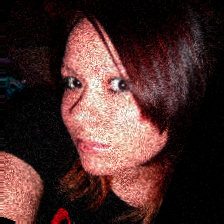

In [50]:
image_show = train_dataset_X[1]
test_out = model(image_show[0].unsqueeze(0).to(device))
from torchvision.transforms.functional import to_pil_image
w = torch.zeros([3,224,224])
w[0] = image_show[0][2]
w[1] = image_show[0][1]
w[2] = image_show[0][0]
weak = w
weak = weak/weak.max()
image_weak = to_pil_image(weak)
image_weak

In [45]:
image_show = train_dataset_U[40]
test_out2 = model(image_show[0].unsqueeze(0).to(device))

In [46]:
test_out1,test_out2

(tensor([[ -9.2697,  -7.8203,  -7.1024,  -7.6689,  -7.1168,  -6.6150,  -5.8889,
           -5.3149,  -5.7538,  -4.8475,  -4.3996,  -3.5532,  -2.9718,  -2.8269,
           -1.9736,  -1.5533,  -0.8074,  -0.6757,   0.2065,   0.2294,   0.5474,
            0.8270,   1.1151,   1.2962,   1.4563,   1.6671,   1.7888,   1.5878,
            1.7872,   1.6256,   1.4205,   1.5082,   1.3641,   1.0592,   1.0418,
            0.9877,   0.6412,   0.4254,   0.1692,  -0.1596,  -0.4819,  -0.9132,
           -1.1873,  -1.2820,  -1.9725,  -2.3681,  -2.6888,  -2.8717,  -2.6575,
           -3.2851,  -3.4079,  -4.3069,  -4.5660,  -4.1780,  -4.9779,  -4.9648,
           -5.4500,  -5.4853,  -6.0197,  -6.9966,  -6.7922,  -7.2908,  -7.3723,
           -7.7458,  -8.1636,  -8.2549,  -9.3380,  -9.8533,  -8.7197,  -8.9545,
           -9.8706,  -9.7184,  -9.6460,  -9.9489, -10.4802, -10.3203, -10.7515,
          -10.5599, -10.9137, -10.9726, -10.7078, -10.7918, -10.6239, -10.2157,
          -11.2713, -11.0425, -11.3899, 

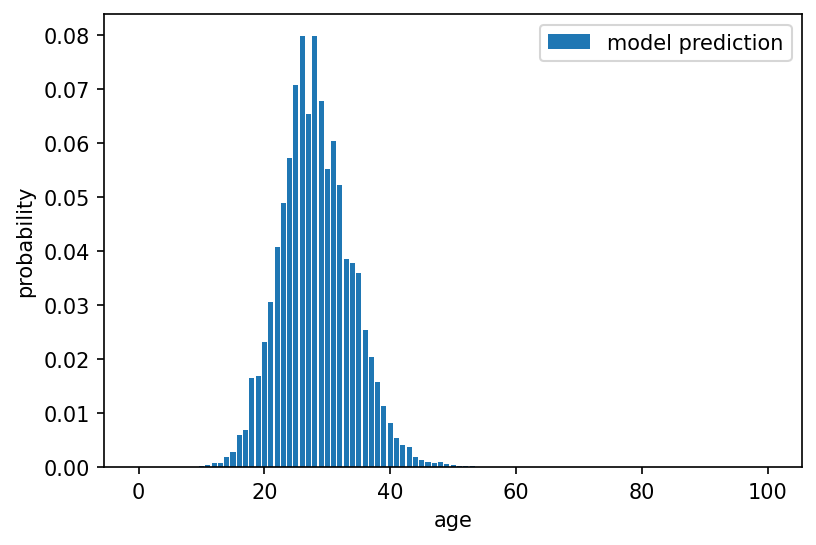

In [47]:
#age_real = image_show[1]
pseudo_label = torch.softmax(test_out1.detach()/1, dim=-1)
pseudo_label = pseudo_label.cpu().numpy()[0]
import matplotlib.pyplot as plt
plt.figure(dpi=150)
plt.xlabel('age')
plt.ylabel('probability')
#plt.axvline(age_real,color="red",label='voted age')
plt.bar(np.arange(0,101),pseudo_label,label='model prediction')
plt.legend()
plt.show()

In [38]:
train_dataset_U[42][0].unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [39]:
test_out = model(train_dataset_U[42][0].unsqueeze(0).to(device))

In [40]:
pseudo_label = torch.softmax(test_out.detach()/1, dim=-1)

In [39]:
pseudo_label

NameError: ignored